In [1]:
import sys, os
sys.path.append('..')

from dataset import load_data
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import utils
from utils import eval_model, visualize_model, train_model
import models
import torchvision.models as models
import train as t
import const

print(torch.cuda.get_device_name(0))

%load_ext autoreload
%autoreload 2

use_gpu = torch.cuda.is_available()
if use_gpu:
    device = torch.device('cuda')
    print ("using CUDA")
else:
    device = torch.device('cpu')
    
print(use_gpu)

Tesla K80
using CUDA
True


In [2]:
train_data, val_data, test_data = load_data()

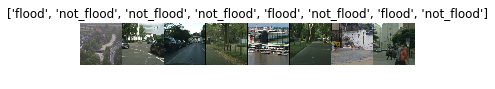

In [3]:
inputs, classes = next(iter(train_data))
utils.show_databatch(inputs, classes)

In [4]:
# load in vgg16 model
if 'heidi' in os.getcwd():
    vgg16 = models.vgg16()
    vgg16.load_state_dict(torch.load("C:/Users/heidi/.torch/models/vgg16-397923af.pth"))
else:
    vgg16 = models.vgg16(pretrained=True)
    
print(vgg16.classifier[6].out_features) # 1000 


# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(classes))]) # Add our layer with 4 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier
print(vgg16)

1000
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): C

In [5]:
if use_gpu:
    vgg16.cuda() #.cuda() will move everything to the GPU side
    
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [6]:
print("Test before training")
eval_model(vgg16, test_data, criterion)

Test before training
Evaluating model
----------
Test batch 200/218
Evaluation completed in 1m 55s
Avg loss (test): 0.2522
Avg acc (test): 0.2755
----------


Ground truth:


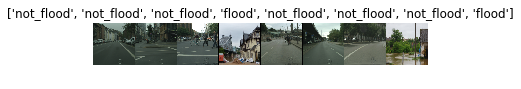

Prediction:


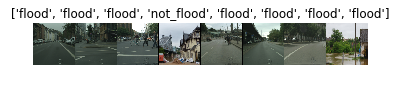

In [7]:
visualize_model(vgg16, test_data) 

In [8]:
vgg16_trained = train_model(train_data, val_data, vgg16, criterion, optimizer_ft, exp_lr_scheduler)
print (vgg16_trained)
torch.save(vgg16.state_dict(), 'itried.pt')

654
5226
Epoch 0/2
----------
0
Training batch 0/327.01
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
Training batch 100/327.0101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
Training batch 200/327.0201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
25

../utils/utils.py:217: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)



Epoch 0 result: 
Avg loss (train): 0.0301
Avg acc (train): 0.9032
Avg loss (val): 0.0000
Avg acc (val): 0.0046
----------


Epoch 0 result: 
Avg loss (train): 0.0301
Avg acc (train): 0.9032
Avg loss (val): 0.0001
Avg acc (val): 0.0086
----------


Epoch 0 result: 
Avg loss (train): 0.0301
Avg acc (train): 0.9032
Avg loss (val): 0.0001
Avg acc (val): 0.0132
----------


Epoch 0 result: 
Avg loss (train): 0.0301
Avg acc (train): 0.9032
Avg loss (val): 0.0001
Avg acc (val): 0.0178
----------


Epoch 0 result: 
Avg loss (train): 0.0301
Avg acc (train): 0.9032
Avg loss (val): 0.0002
Avg acc (val): 0.0218
----------


Epoch 0 result: 
Avg loss (train): 0.0301
Avg acc (train): 0.9032
Avg loss (val): 0.0002
Avg acc (val): 0.0264
----------


Epoch 0 result: 
Avg loss (train): 0.0301
Avg acc (train): 0.9032
Avg loss (val): 0.0004
Avg acc (val): 0.0304
----------


Epoch 0 result: 
Avg loss (train): 0.0301
Avg acc (train): 0.9032
Avg loss (val): 0.0004
Avg acc (val): 0.0350
----------


Epoch 0


Epoch 0 result: 
Avg loss (train): 0.0301
Avg acc (train): 0.9032
Avg loss (val): 0.0064
Avg acc (val): 0.2945
----------


Epoch 0 result: 
Avg loss (train): 0.0301
Avg acc (train): 0.9032
Avg loss (val): 0.0065
Avg acc (val): 0.2985
----------


Epoch 0 result: 
Avg loss (train): 0.0301
Avg acc (train): 0.9032
Avg loss (val): 0.0066
Avg acc (val): 0.3031
----------


Epoch 0 result: 
Avg loss (train): 0.0301
Avg acc (train): 0.9032
Avg loss (val): 0.0066
Avg acc (val): 0.3077
----------


Epoch 0 result: 
Avg loss (train): 0.0301
Avg acc (train): 0.9032
Avg loss (val): 0.0066
Avg acc (val): 0.3123
----------


Epoch 0 result: 
Avg loss (train): 0.0301
Avg acc (train): 0.9032
Avg loss (val): 0.0066
Avg acc (val): 0.3169
----------


Epoch 0 result: 
Avg loss (train): 0.0301
Avg acc (train): 0.9032
Avg loss (val): 0.0069
Avg acc (val): 0.3209
----------


Epoch 0 result: 
Avg loss (train): 0.0301
Avg acc (train): 0.9032
Avg loss (val): 0.0071
Avg acc (val): 0.3249
----------


Epoch 0


Epoch 0 result: 
Avg loss (train): 0.0301
Avg acc (train): 0.9032
Avg loss (val): 0.0125
Avg acc (val): 0.5809
----------


Epoch 0 result: 
Avg loss (train): 0.0301
Avg acc (train): 0.9032
Avg loss (val): 0.0131
Avg acc (val): 0.5838
----------


Epoch 0 result: 
Avg loss (train): 0.0301
Avg acc (train): 0.9032
Avg loss (val): 0.0133
Avg acc (val): 0.5878
----------


Epoch 0 result: 
Avg loss (train): 0.0301
Avg acc (train): 0.9032
Avg loss (val): 0.0133
Avg acc (val): 0.5924
----------


Epoch 0 result: 
Avg loss (train): 0.0301
Avg acc (train): 0.9032
Avg loss (val): 0.0135
Avg acc (val): 0.5964
----------


Epoch 0 result: 
Avg loss (train): 0.0301
Avg acc (train): 0.9032
Avg loss (val): 0.0137
Avg acc (val): 0.6005
----------


Epoch 0 result: 
Avg loss (train): 0.0301
Avg acc (train): 0.9032
Avg loss (val): 0.0137
Avg acc (val): 0.6051
----------


Epoch 0 result: 
Avg loss (train): 0.0301
Avg acc (train): 0.9032
Avg loss (val): 0.0138
Avg acc (val): 0.6096
----------


Epoch 0

Validation batch 200/218
Epoch 0 result: 
Avg loss (train): 0.0301
Avg acc (train): 0.9032
Avg loss (val): 0.0190
Avg acc (val): 0.8703
----------


Epoch 0 result: 
Avg loss (train): 0.0301
Avg acc (train): 0.9032
Avg loss (val): 0.0192
Avg acc (val): 0.8737
----------


Epoch 0 result: 
Avg loss (train): 0.0301
Avg acc (train): 0.9032
Avg loss (val): 0.0192
Avg acc (val): 0.8783
----------


Epoch 0 result: 
Avg loss (train): 0.0301
Avg acc (train): 0.9032
Avg loss (val): 0.0193
Avg acc (val): 0.8823
----------


Epoch 0 result: 
Avg loss (train): 0.0301
Avg acc (train): 0.9032
Avg loss (val): 0.0194
Avg acc (val): 0.8863
----------


Epoch 0 result: 
Avg loss (train): 0.0301
Avg acc (train): 0.9032
Avg loss (val): 0.0194
Avg acc (val): 0.8909
----------


Epoch 0 result: 
Avg loss (train): 0.0301
Avg acc (train): 0.9032
Avg loss (val): 0.0195
Avg acc (val): 0.8949
----------


Epoch 0 result: 
Avg loss (train): 0.0301
Avg acc (train): 0.9032
Avg loss (val): 0.0195
Avg acc (val): 0.8

In [9]:
eval_model(vgg16_trained, criterion)

TypeError: eval_model() missing 1 required positional argument: 'criterion'

Ground truth:


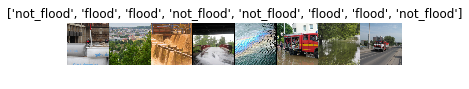

Prediction:


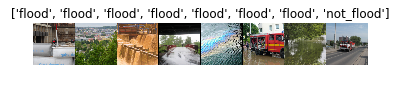

In [15]:
visualize_model(vgg16_trained)

In [31]:
#??
#load pre-trained flooding weights from dataset
pkl_filename = "../features/VGG16_relu5_3.pickle"  
last_layer_weights = {} # pretrained_weights is an empty dict already

if os.path.getsize(pkl_filename) > 0:      
    with open(pkl_filename, "rb") as f:
        unpickler = pickle.Unpickler(f)
        # if file is not empty scores will be equal
        # to the value unpickled
        last_layer_weights = unpickler.load()
        
print (last_layer_weights['pollution_1'].shape)